## Describe noise, outliers, and missing data.


- “Garbage in, garbage out” -> Good data sets are essential for a good model
- Noise
    - Unwanted data
        - Duplicates
            - Class Imbalance?
        - Irrelevant
- Outliers
    - Only remove if we have a legitimate reason
    - Can cause problems for linear regression models -> removing outliers could help performance
- Missing data - strategies
    - Common ways
        - Dropping observations with missing values
        - Imputing the missing values based on other observations
            - Using most frequent or default values
                - Easy to implement, but skews data in weird ways if a lot of data is missing. 
                - Doesn’t relate to the rest of the collected data can give weird results
            - Using mean/median values
                - Context is not considered. We still just fill with a constant value, but it’s at least the mean instead of 0
            - Linear (time-series) interpolation over time
                - Is context aware and as such will give us values that will more closely correspond to other values in the current time frame. This gives us a much closer expected value to other poses seen.
            - *This is outside of exercises*
            - Using k-NN
            - Using Multivariate Imputation by Chained Equation
            - Using Deep Learning
    - Correlation
        - Whichever fill method produced a correlation matrix that looked the most like the original unaltered data correlation matrix (no missing) was closest to generating values that matched it. 


## Focus on uncertainty, noise, data cleaning in relation to regression, classification, clustering or dimensionality reduction (Covariance, distributions (e.g Normal/Gaussian))

- Uncertainty
    - Noise, incomplete dataset, duplicate data
    - Noise makes it hard to see what model type might be good,because it’s hard to tell if data point is part of the ground truth or just noisy
- Noise
    - Structured noise
        - The noise has some predictable structure that can be used to denoise it
    - Random noise
        - Just random garbage not predictable
            - We must use destructive measures to get rid of which may affect the GT data
    - Unwanted data
        - Duplicates
            - Class Imbalance?
        - Irrelevant

- Data cleaning
    - If structure noise we can try and find the pattern reverse the effect
    - If random noise then we can blur / smooth with e.g. Gaussian filter
    - Outliers can be removed by setting a threshold
        - Don’t want to remove actual meaningful datapoints
- Dimensionality reduction
    - lots of noise might make it hard to find the meaningful dimensions of the data to keep
- Covariance
    - Relationship between the variables 
        - Prone to skewing from high variance variables
    - Formula:  $$
                \text{Covariance: }\newline  \text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})
                $$


# Descriptive Statistics and Handling Missing Data in Pose Data Sequences
This exercise descriptive statistics and managing missing data, particularly within a slightly intricate dataset comprising fixed-length skeleton data sequences. Moreover, it encompasses the evaluation of the efficacy of these methodologies.
The primary objective is to implement and scrutinize various techniques for managing absent data points, ensuring a comprehensive and unblemished dataset for subsequent analyses.
### Pose Data Overview
In the subsequent cell, the ground truth dataset is loaded alongside an identical yet noise-infused counterpart. This involves a 30-frame time series sequence, capturing human poses with each frame encompassing 25_2 features, namely the x and y coordinates for 25 skeletal joints. We'll generate 200 such sequences, forming a dataset with a shape of ( (200, 30, 25_2) ).
#### Handling Missing Values
From the ground truth dataset (`GT_poses`
), data has been intentionally omitted, thereby creating the `Noisy_poses`
 dataset wherein 30% of the original values have been randomly substituted with NaN values (`np.nan`
). The ensuing step involves implementing and evaluating varied strategies for dealing with these missing data points, ensuring the robustness of the eventual analyses derived from this dataset.

<article class="message">
    <div class="message-body">
        <strong>List of tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#filling_zeros">Task 1: Filling missing data - zeros</a>
            </li>
            <li>
            <a href="#mean_impute">Task 2: Mean imputer</a>
            </li>
            <li>
            <a href="#temp_interpolation">Task 3: Temporal interpolation</a>
            </li>
            <li>
            <a href="#evaluation">Task 4: Adjust data and evaluate</a>
            </li>
            <li>
            <a href="#method_comp">Task 5: Method comparison</a>
            </li>
            <li>
            <a href="#Mean">Task 6: Mean pose and pose sequence</a>
            </li>
            <li>
            <a href="#Correlation">Task 7: Correlation between features</a>
            </li>
        </ul>
    </div>
</article>



In [4]:
## Load the data 
# give a title - to this box
# Title
## import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme (handles most styling)
sns.set_theme(style="whitegrid")

# Optional: try to apply a Seaborn-like Matplotlib style if available
for candidate in ['seaborn-v0_8', 'seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'seaborn-darkgrid']:
    if candidate in plt.style.available:
        plt.style.use(candidate)
        break

# Set random seed for reproducibility
np.random.seed(42)


GT_poses  = np.load("data/Input_Poses.npy")
Noisy_poses = np.load('data/Noisy_poses.npy')

N,T,D,C = Noisy_poses.shape
GT_poses = GT_poses.reshape(N,T,D*C)
Noisy_poses = Noisy_poses.reshape(N,T,D*C)

Plotting functions are provided in the cell below. It is not required to understand or modify any of these functions to complete the exercise.


In [5]:
def limb_number_plot(s_pose_x,s_pose_y,n1,n2,c="red",label=None):
  if label is not None:
    if (s_pose_x[n1]>0) and (s_pose_x[n2]>0) and (s_pose_y[n1]>0) and (s_pose_y[n2]>0): 
      plt.plot([s_pose_x[n1],s_pose_x[n2]], [s_pose_y[n1], s_pose_y[n2]],color = c, linestyle="-",label=label)
  else:
    if (s_pose_x[n1]>0) and (s_pose_y[n1]>0):
       plt.plot(s_pose_x[n1], s_pose_y[n1],'*',color = c,label=label)
    if (s_pose_x[n2]>0) and (s_pose_y[n2]>0):
       plt.plot(s_pose_x[n2], s_pose_y[n2],'*',color = c,label=label)
    if (s_pose_x[n1]>0) and (s_pose_x[n2]>0) and (s_pose_y[n1]>0) and (s_pose_y[n2]>0):
      plt.plot([s_pose_x[n1],s_pose_x[n2]], [s_pose_y[n1], s_pose_y[n2]],color = c, linestyle="-")

def plot_single_pose(s_pose,c = "darkgreen",label=None,ds='body_25',c_head = 'red',head = True):
    
    s_pose_x=s_pose[::2]
    s_pose_y=s_pose[1::2]
    #torso/body
    limb_number_plot(s_pose_x,s_pose_y,2,5,c)
    if label is not None:

        limb_number_plot(s_pose_x,s_pose_y,9,12,c,label)
    else:
        limb_number_plot(s_pose_x,s_pose_y,9,12,c)
    limb_number_plot(s_pose_x,s_pose_y,2,9,c)
    limb_number_plot(s_pose_x,s_pose_y,5,12,c)

    #left arm (person facing away)
    limb_number_plot(s_pose_x,s_pose_y,2,3,c)
    limb_number_plot(s_pose_x,s_pose_y,3,4,c)

    #right arm
    limb_number_plot(s_pose_x,s_pose_y,5,6,c)
    limb_number_plot(s_pose_x,s_pose_y,6,7,c)

    #left leg / foot
    limb_number_plot(s_pose_x,s_pose_y,9,10,c)
    limb_number_plot(s_pose_x,s_pose_y,10,11,c)
    limb_number_plot(s_pose_x,s_pose_y,11,22,c)
    #right leg / foot
    limb_number_plot(s_pose_x,s_pose_y,12,13,c)
    limb_number_plot(s_pose_x,s_pose_y,13,14,c)
    limb_number_plot(s_pose_x,s_pose_y,14,19,c)

    # head
    if head:
        limb_number_plot(s_pose_x,s_pose_y,0,15,c)
        limb_number_plot(s_pose_x,s_pose_y,0,16,c)

        limb_number_plot(s_pose_x,s_pose_y,15,17,c)
        limb_number_plot(s_pose_x,s_pose_y,16,18,c)
    return True 

import math
import matplotlib.pyplot as plt

def plot_single_sequence(poses, pose_name='Poses', color='blue', max_cols=10):
    """
    Plot a sequence of skeleton poses (frames) in a grid layout.

    Parameters
    ----------
    poses : array-like
        Skeleton sequence data, shape (T, D).
    pose_name : str, optional
        Title prefix for each frame (default: 'Poses').
    color : str, optional
        Color of the skeleton (default: 'blue').
    max_cols : int, optional
        Maximum number of columns for subplots (default: 10).
    """
    T = len(poses)
    ncols = min(max_cols, max(1, T))
    nrows = math.ceil(T / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(2.0 * ncols, 2.0 * nrows))
    fig.suptitle(
        'Ground truth' if pose_name.lower() in ('gt', 'ground truth') else pose_name,
        y=0.98,
        fontsize=16
    )

    # Flatten axes to simplify iteration
    if not isinstance(axes, (list, tuple, np.ndarray)):
        axes = np.array([axes])
    axes = axes.ravel()

    for i in range(T):
        ax = axes[i]
        plt.sca(ax)
        plot_single_pose(poses[i], c=color, head=False)  # assumes you have this defined
        ax.set_ylim(1, 0)
        ax.set_xlim(-1, 1)
        ax.set_title(f"{pose_name}{i}", fontsize=10)
        ax.axis('off')

    # Hide extra axes if any
    for j in range(T, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()

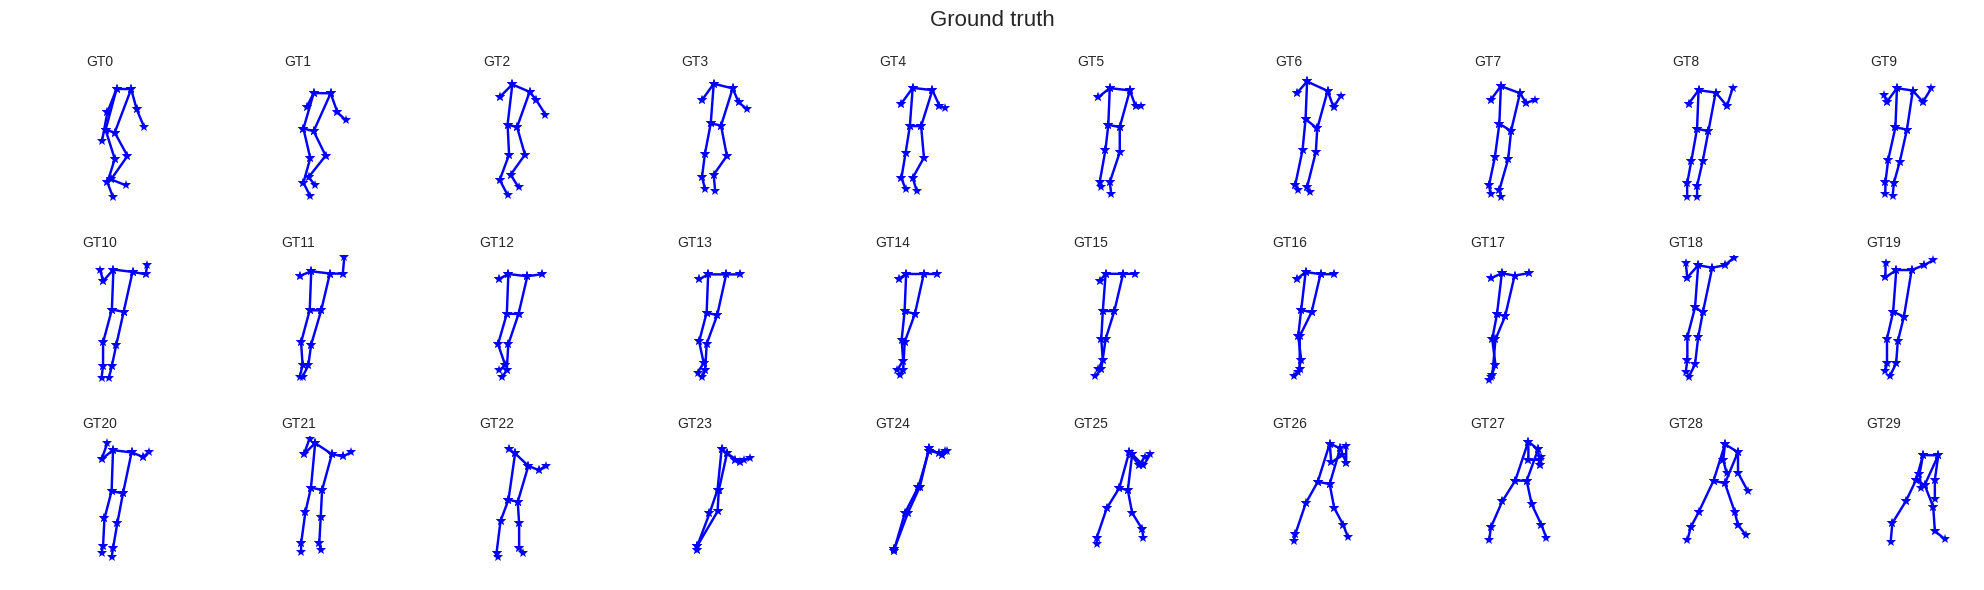

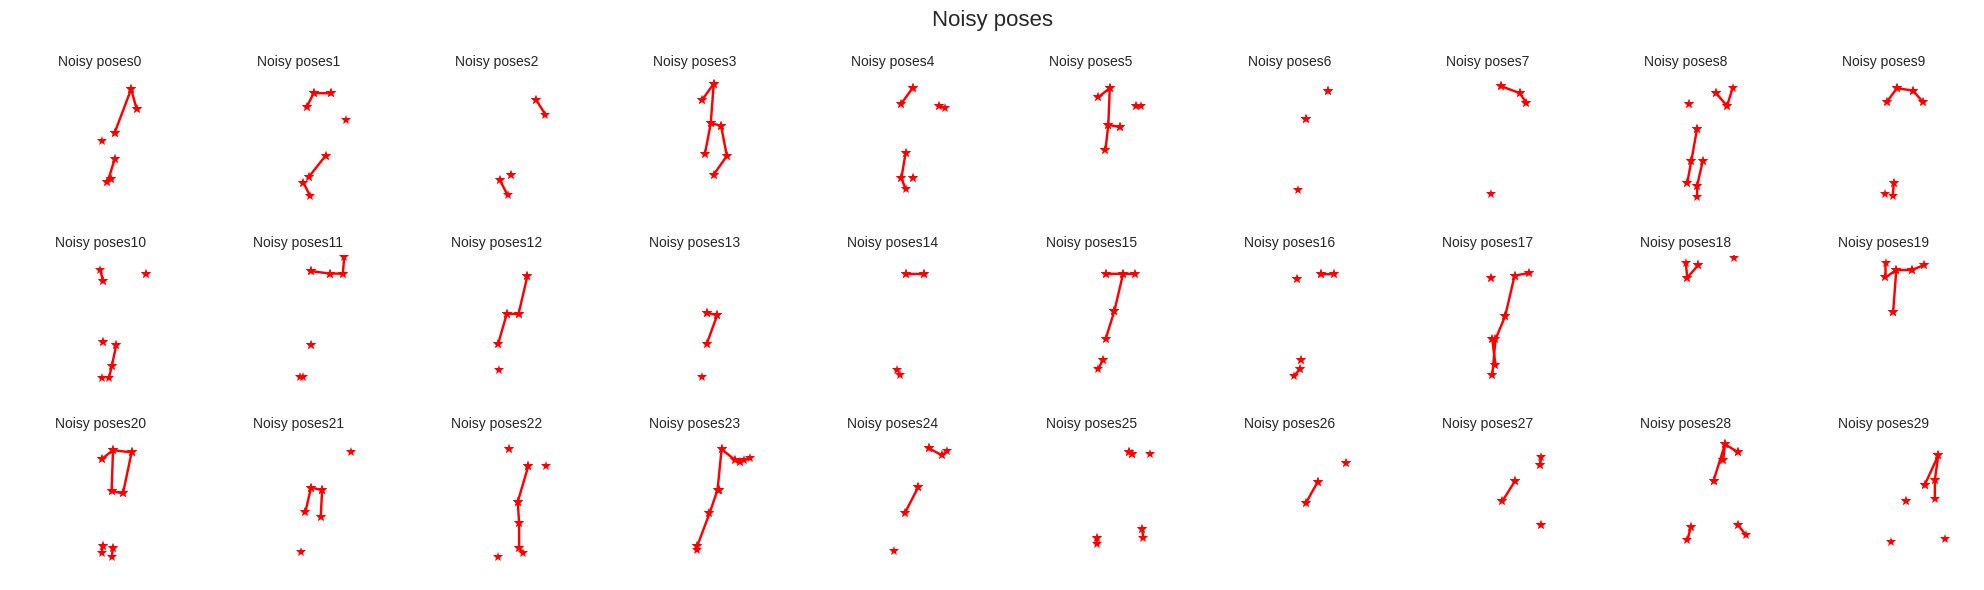

In [6]:
## Plot a random single sequence of both the noisy and ground truth skeleton data.
np.random.seed(12)
sample = np.random.randint(0,200)
plot_single_sequence(GT_poses[sample],pose_name='GT',color='blue')
plot_single_sequence(Noisy_poses[sample],pose_name='Noisy poses',color='red')

### Missing data strategies
In the following steps we will learn 3 different methods for handling missing data. 
1. Inserting zeros
2. Inserting means
3. Linear interpolation over time


---
**Task 1 (easy): Filling missing data - zeros👩‍💻**
Implement the first of 3 different methods for filling in missing data in the `Noisy_poses`
 in the cell below. The approach `filling_missing`
 should fill missing entries in the data sequences (`np.nan`
-values)with a zeros.
**Note:** (Hint: the function `np.isnan`
 can be used to find indices containing NaN values.)


---

In [46]:
from copy import deepcopy

## Method 1: Flling missing entries with 0s
def filling_missing(data):
    """
    Fills missing entries in the given data with a specified value.

    Parameters:
    - data (numpy.array): 3D numpy array with shape (num_samples, seq_len, num_features) containing data entries.
    - filling (int or float): The value used to fill missing entries.

    Returns:
    - numpy.array: Data with missing entries filled using the specified value.
    """
    #write code here ...
    imputed_data = deepcopy(data)
    num_samples, seq_len, num_features = imputed_data.shape

    for i in range(num_samples):
        for j in range(num_features):
            ts = imputed_data[i, :, j]
            for index in range(len(ts)):
                if np.isnan(ts[index]):
                    ts[index] = 0

            imputed_data[i, :, j] = ts

    return imputed_data


---
**Task 2 (medium): Mean imputer👩‍💻**
Implement the `mean_imputer`
 function below. The function should contain:
- Extract `data`
 shape and create a copy, `imputed_data`
, for imputation.

- Loop through each feature in `imputed_data`
.

- Compute the mean, identify `np.nan`
 indices, and replace them with the mean.

- Ensure `imputed_data`
 is returned, with all `np.nan`
 entries imputed.



---

In [45]:
## Method 2: Mean impute
def mean_imputer(data):
    """
    Imputes missing entries in the given data using the mean value of the features.

    Parameters:
    - data (numpy.array): 3D numpy array with shape (num_samples, sequence_len, num_features) containing data entries.

    Returns:
    - numpy.array: Data with missing entries imputed using the mean value.
    """
    #write code here ...

    imputed_data = deepcopy(data)
    num_samples, seq_len, num_features = imputed_data.shape

    for i in range(num_samples):
        for j in range(num_features):
            ts = imputed_data[i, :, j]
            mean_val = np.nanmean(ts)

            for index in range(len(ts)):
                if np.isnan(ts[index]):
                    ts[index] = mean_val

            imputed_data[i, :, j] = ts

    return imputed_data


---
**Task 3 (hard): Temporal interpolation👩‍💻**
Define the function `time_series_interpolation(data)`
 with `data`
 as a 3D numpy array input.
- Extract the shape of `data`
 and create a copy named `interpolated_data`
 to perform operations without altering the original data.

- Implement nested for-loops to iterate through each sample (i) and each feature (j) in `interpolated_data`
.

- Inside the nested loops:
    - Retrieve the time series sequence for the current sample and feature.
    - Handle cases for the first element being `np.nan`
 by finding the next available value in the sequence and imputing the `np.nan`
 using a suitable replacement logic.
    - Iterate through the time series (k), locating `np.nan`
 entries, and implementing logic to interpolate values, ensuring handling of consecutive `np.nan`
 entries.
    - Account for the scenario where the last element is `np.nan`
, replacing it with the second-to-last element.


- Have the function return `interpolated_data`
 with all `np.nan`
 entries interpolated.



---

In [24]:
## Mehtod 3:Temporal approach
def time_series_interpolation(data):
    """
    Performs time series interpolation to fill missing entries in the given data.

    Parameters:
    - data (numpy.array): 3D numpy array with shape (num_samples, sequence_len, num_features) containing data entries.

    Returns:
    - numpy.array: Data with missing entries filled using time series interpolation.
    """
    #write code here ...

    interp_data = deepcopy(data)
    num_samples, seq_len, num_features = interp_data.shape

    for i in range(num_samples):
        for j in range(num_features):
            ts = interp_data[i, :, j]

            nan_coords = []
            notNan_coords = []
            for index in range(len(ts)):
                if np.isnan(ts[index]):
                    nan_coords.append(index)
                else:
                    notNan_coords.append(index)
            knowData = [ts[u] for u in notNan_coords]
            values = list(np.interp(nan_coords, notNan_coords, knowData))
            for index in reversed(nan_coords):
                ts[index] = values.pop()
            
            interp_data[i, :, j] = ts

    return interp_data
    
    

### Apply and evaluate approaches
#### Error function (MSE)
The function  `MSE`
 that find the mean squared error between the adjusted and ground truth data.
- the MSE can be averaged across different dimensions of the skeleton pose data array such that average loss across each step of the time seqeunce ('Temporal') or the loss across each joints/features ('Joint') is calculated.


In [14]:
def MSE(Noisy,GT,avg='Temporal'):
    loss = (Noisy - GT) ** 2
    if avg=='Temporal':
        loss = loss.mean(axis=(0,2))
    elif avg == "Joint":
        loss = loss.mean(axis=(0,1))
    else:
        loss  = loss.mean()
    return loss


---
**Task 4 (easy): Adjust data and evaluate👩‍💻**
Evaluate the performance of each imputation approach by comparing the adjusted data to the ground truth seqeunces using the `MSE`
 function. The task is done in the following steps.
1. Adjust the noisy data with an imputation method.
2. Calculate the _mean squared error_ between the adjusted and ground truth poses, by using the function `MSE`
. 
3. Repeat for the remaining methods.


---

In [83]:
### Apply the 3 missing data measures to the noisy data and calculate their respective MSE
##example
adjusted_data1 = filling_missing(Noisy_poses)
error1 = MSE(adjusted_data1,GT_poses,avg='None')
print(f'The MSE of the data adjusted with filling in zeros: {error1}')

adjusted_data2 = mean_imputer(Noisy_poses)
error1 = MSE(adjusted_data2,GT_poses,avg='None')
print(f'The MSE of the data adjusted with filling in zeros: {error1}')

adjusted_data3 = time_series_interpolation(Noisy_poses)
error1 = MSE(adjusted_data3,GT_poses,avg='None')
print(f'The MSE of the data adjusted with filling in zeros: {error1}')

The MSE of the data adjusted with filling in zeros: 0.053628125275375645
The MSE of the data adjusted with filling in zeros: 0.0030555577802692663
The MSE of the data adjusted with filling in zeros: 0.0013447281272547676


### Plotting
#### Plot error distances
In the cell below, the MSE is plotted between the ground truth and adjusted poses, averaging both over the joints and the temporal sequence.


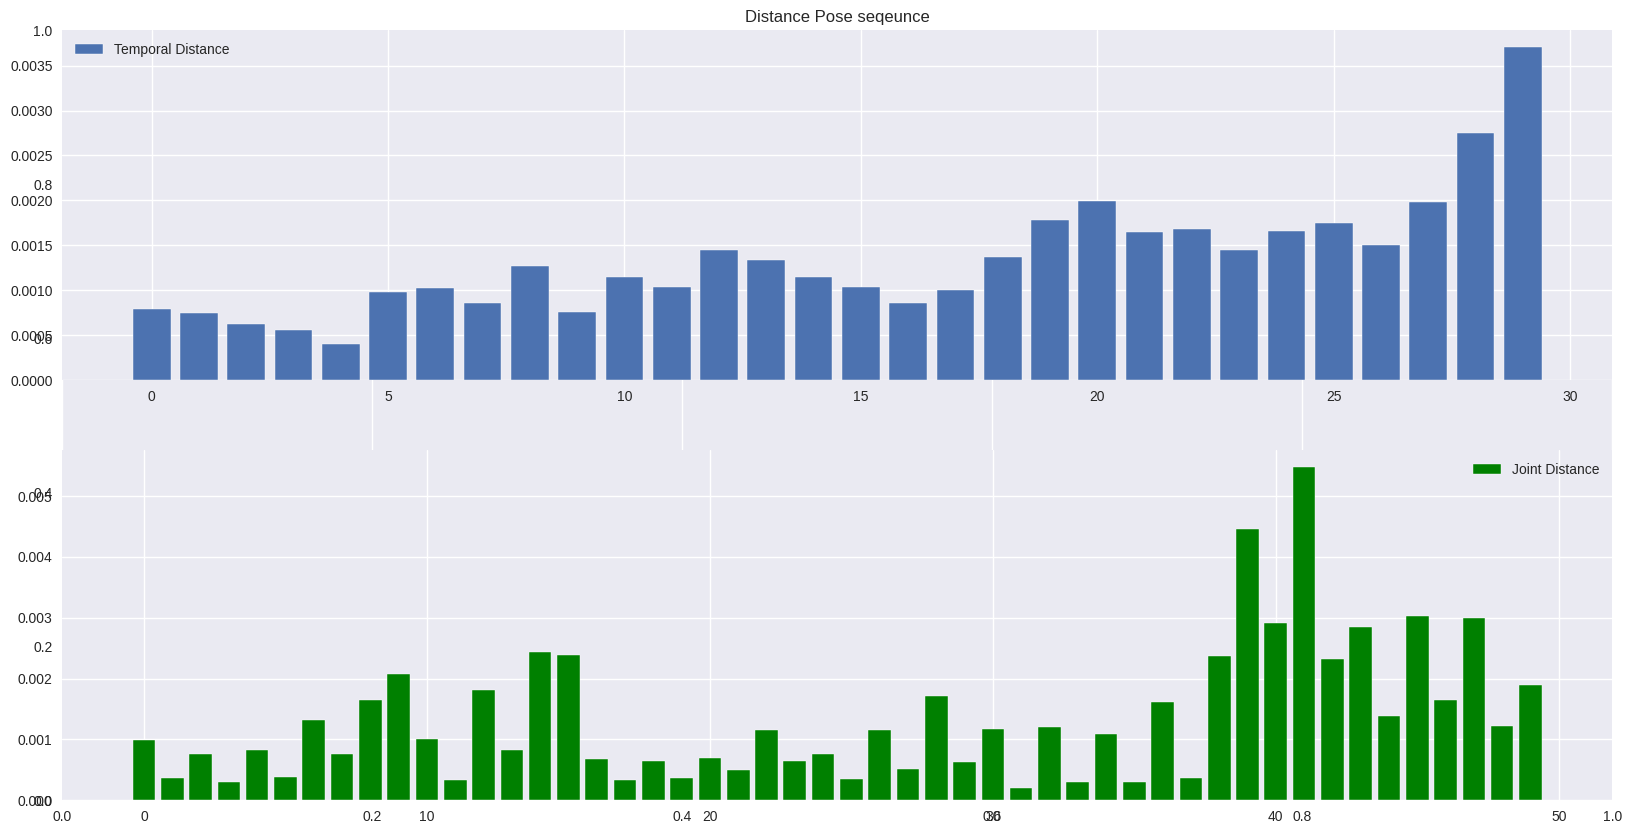

In [50]:
## Your should only run this cell after completing the exercise above
Dist1 = MSE(adjusted_data3,GT_poses)
plt.figure(figsize=(20,10))
plt.title('Distance Pose seqeunce')
plt.subplot(2,1,1)
plt.bar(np.arange(len(Dist1)), Dist1, align='center',label='Temporal Distance')
plt.legend()
plt.subplot(2,1,2)
Dist2 = MSE(adjusted_data3,GT_poses,avg='Joint')
plt.bar(np.arange(len(Dist2)), Dist2, align='center',color='green',label='Joint Distance')
plt.legend();

#### Plotting GT, noisy and adjusted poses


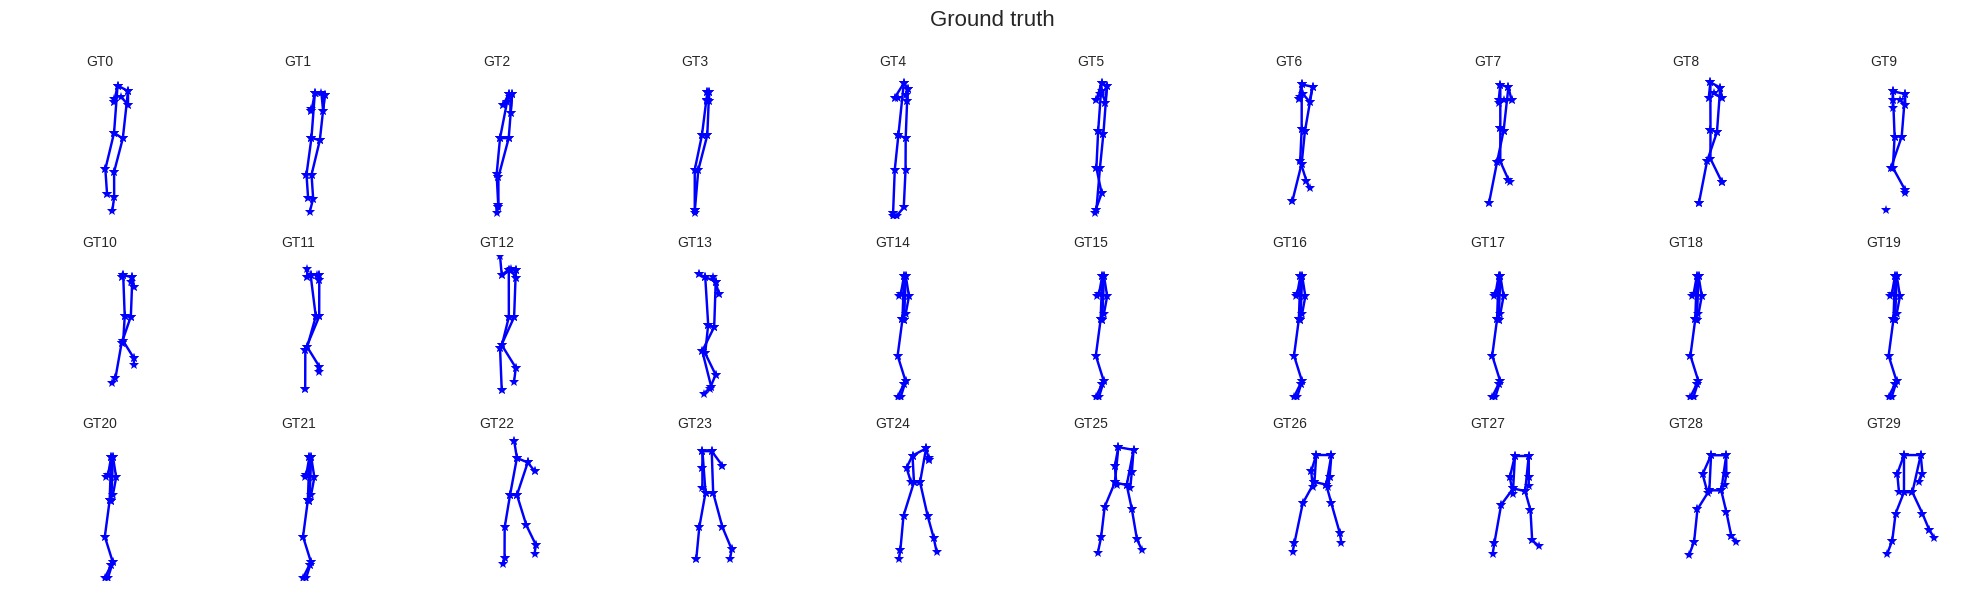

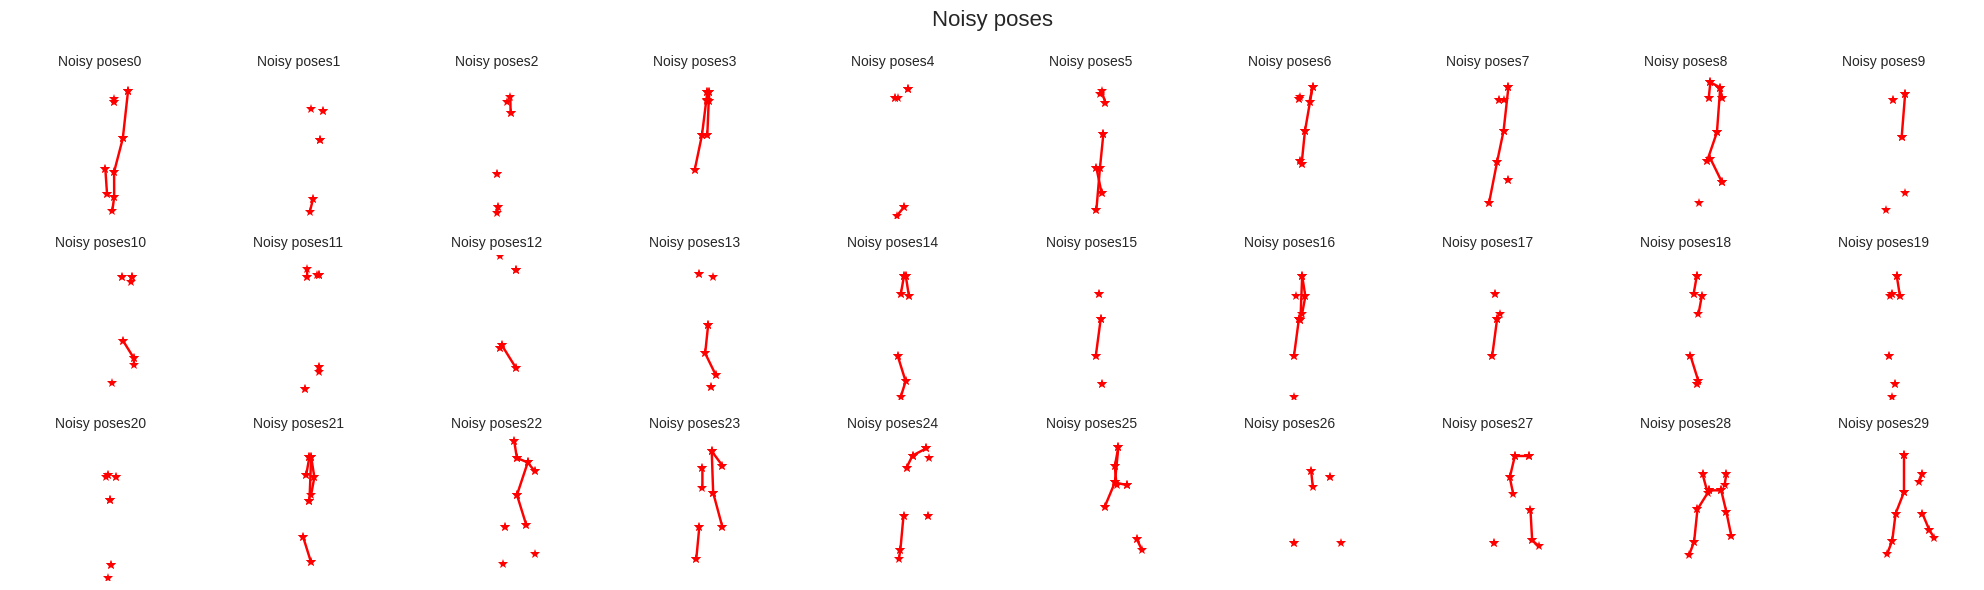

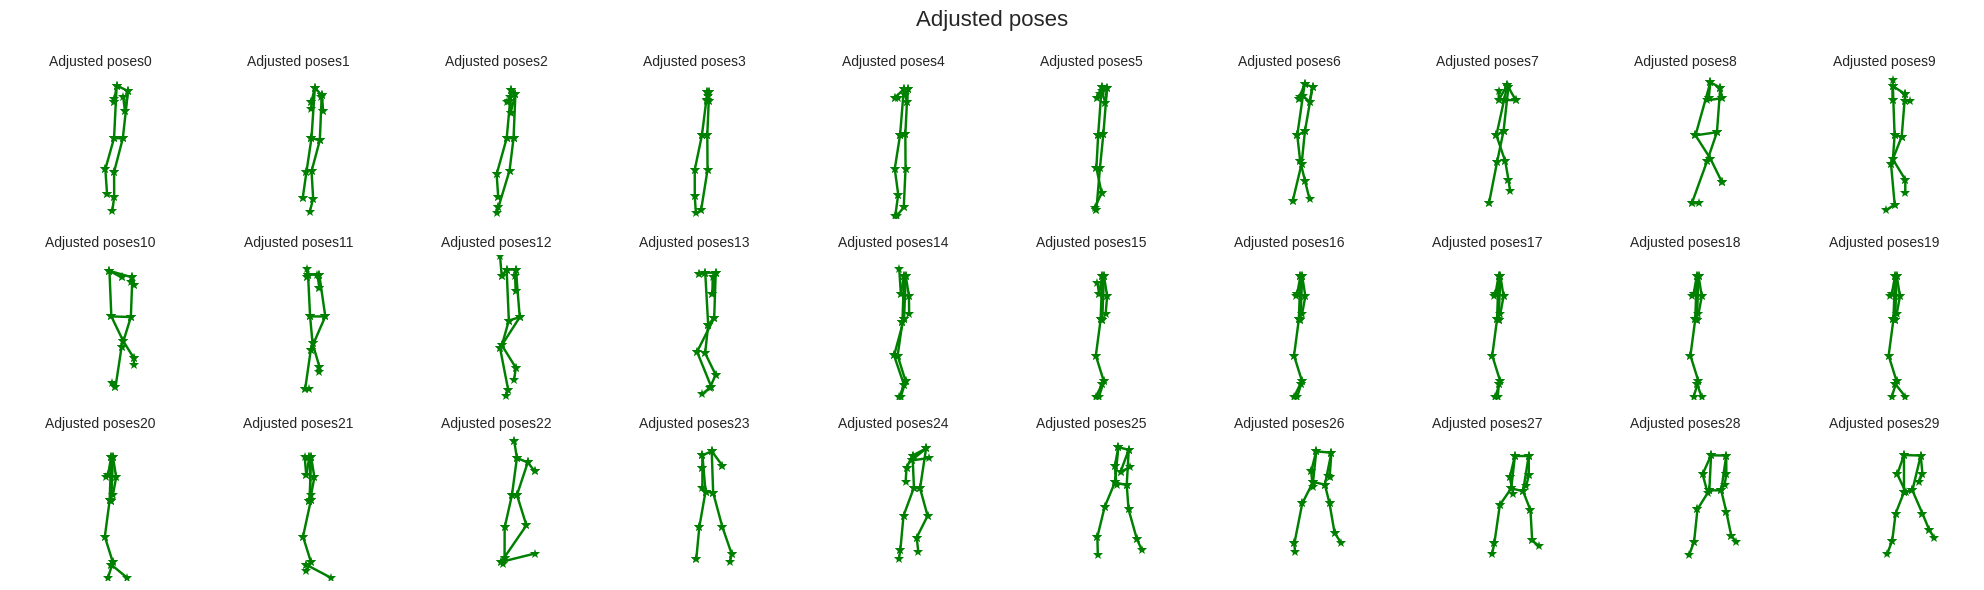

In [55]:
## Your should only run this cell after completing the exercise above
## Plot a random single sequence of the noisy, ground truth and adjusted skeleton data.
np.random.seed(42)
sample = np.random.randint(0,200)
plot_single_sequence(GT_poses[sample],pose_name='GT',color='blue')
plot_single_sequence(Noisy_poses[sample],pose_name='Noisy poses',color='red')
plot_single_sequence(adjusted_data3[sample],pose_name='Adjusted poses',color='green')


---
**Task 5 (medium): Method comparison💡📽️**
1. Analyze the mean squared error (MSE), and inspect the adjusted pose sequences for each missing data approach and discuss the advantages and disadvantages of each method.


---

In [0]:
# Write your answers here
"""
For filling with 0, we don't really get any more data. We just get rid of nan
For mean gives us more data than the filling with 0 but we don't consider the specific pose when filling data.
For time series_interpolation we get an output that cares more about where we are in the time series to try to create a more relevant point. 
"""

### Descriptive statistics for evaluating imputation method
As a final step, we need to evaluate how the missing value imputation procedure affects the statistical properties of the data. Specifically, we will focus on the mean and the covariance of both the original and the imputed poses.

---
**Task 6 (medium): Mean pose and pose sequence👩‍💻💡📽️**
The cell below contains code for plotting the original mean pose sequence. First run the cell, then modify the code to:
- Plot the mean sequence after filling in the missing values with zeros.
- Compare the two plots. Do you observe any differences? If yes, what could be the reason behind these differences and what insights can they provide regarding the characteristics of the mean?
- Plot the mean pose (not a sequence of poses, but a single pose) for the ground truth data and for the imputed datasets as well. Do you observe any differences between the mean pose (or the scale of the pose) in any of the plots?
- Based on the way in which the mean is calculated, is the mean sequence of poses or the mean pose more affected by the imputation process for missing data?


---

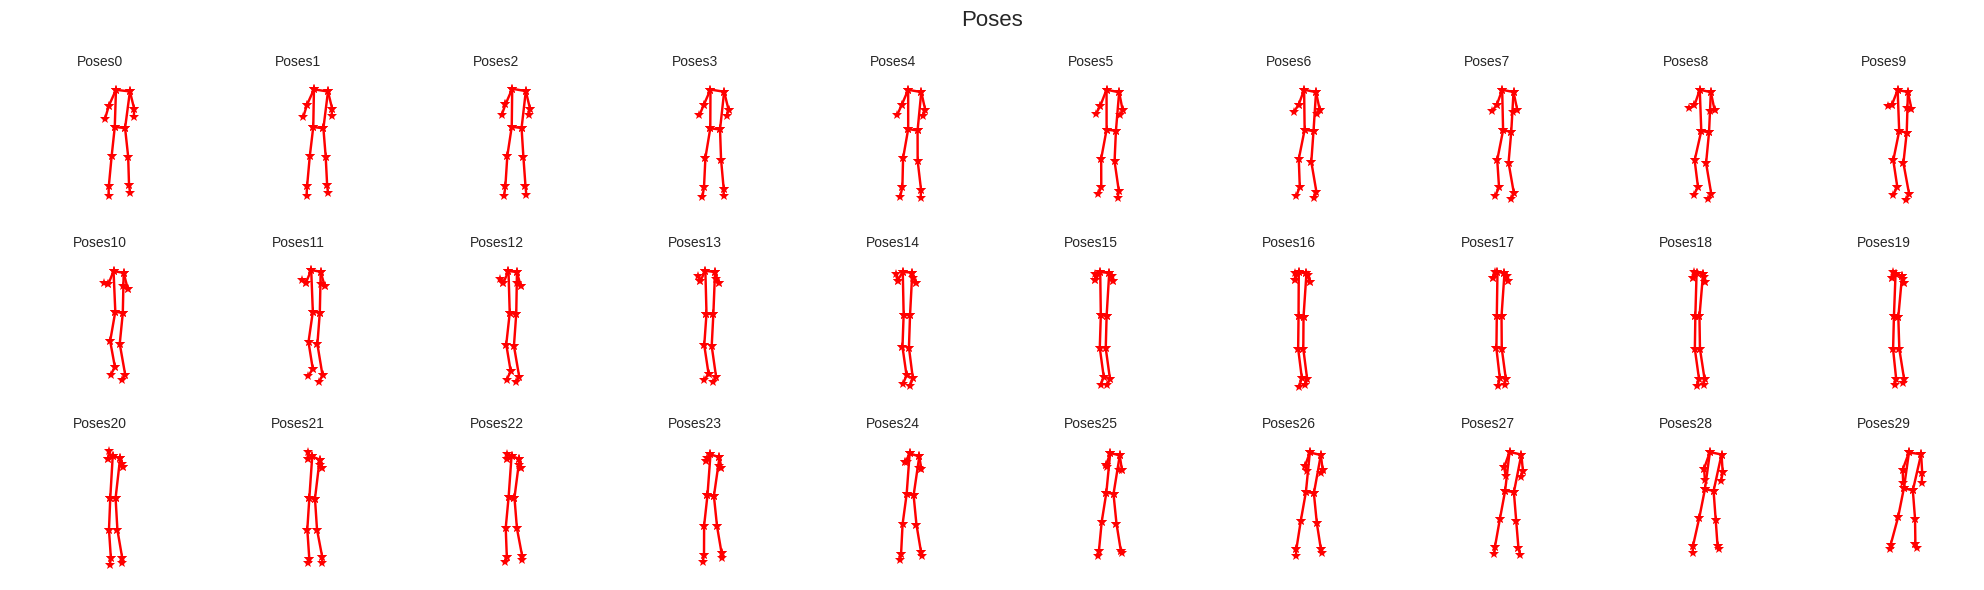

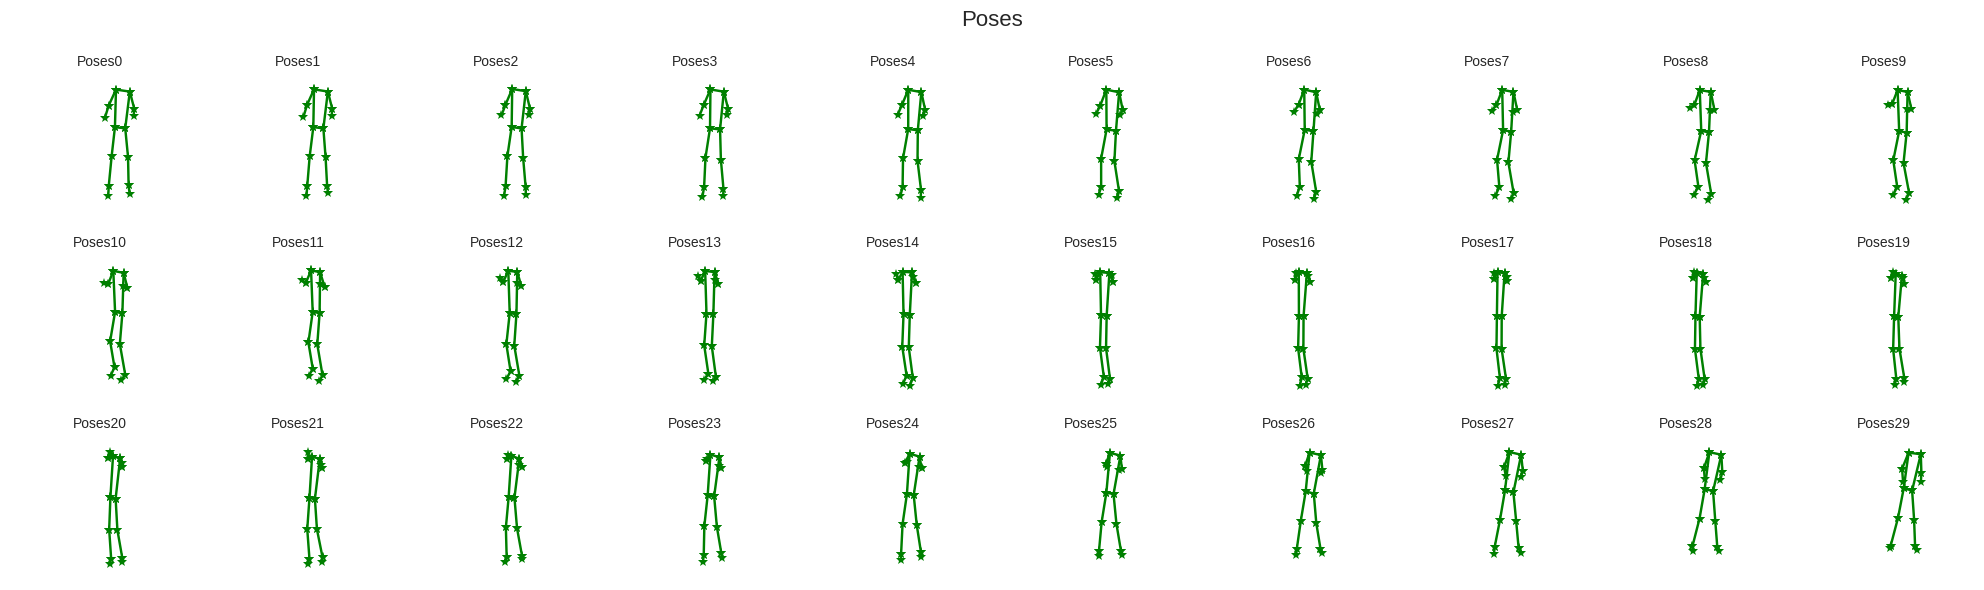

'\nThe mean pose is more affected than the sequence because that include all the global points while the sequence is only affected be each poses own values.\n'

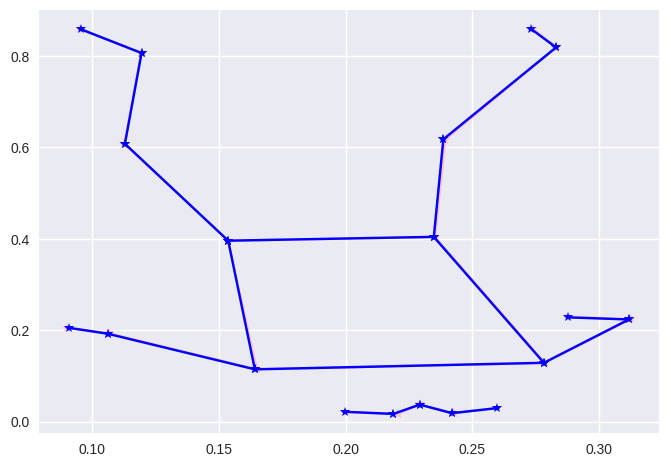

In [84]:
## Plotting the mean sequence
plot_single_sequence(GT_poses.mean(axis=(0)),color='red')

# Your solution goes here
plot_single_sequence(adjusted_data3.mean(axis=(0)),color='green')
"""
Well since we are just filling with 0 that mean that the mean data gets squished more towards 0. 
"""

plot_single_pose(GT_poses.mean(axis=(0,1)), c="pink")
plot_single_pose(adjusted_data3.mean(axis=(0,1)), c="blue")

"""
We can see that the imputed mean pose is smaller which makes sense because the mean is moved towards 0
"""
"""
The mean pose is more affected than the sequence because that include all the global points while the sequence is only affected be each poses own values.
"""

In addition to analyzing the data's mean, we also need to investigate how the different imputation methods impact the relationship between variables. The tutorial demonstrated that correlation matrices are useful for quantifying how multiple variables co-vary. Throughout the next task we generate multiple correlation matrices to examine whether the relationship between features/joints is preserved by the way we handled missing data:

---
**Task 7 (easy): Correlation between features👩‍💻💡📽️**
This task is divided into multiple steps, as we need to construct and compare multiple correlation matrices:

**Info**
In the tutorial the correlation matrix was generated using the corr() function, which is exclusively applicable to Pandas DataFrames. In the current exercises we are working with a Numpy array. The correlation matrix for such an array can be obtained using the np.corrcoef() function.


The cell below contains code for pre-processing the ground truth dataset and constructing the correlation matrix:
1. Run the code and modify it to obtain a correlation matrix for each of the imputed datasets.
2. Compare the correlation matrices:    - Do any of the imputation methods preserve the original relationships between joints?
    - Does it have any significance whether the original relationship is preserved?


3. Based on the MSE scores, the visual inspection, and the inspection of statistical properties, which imputation method would you chose for the current dataset and why? List at least 5 different reasons for your choice.


---

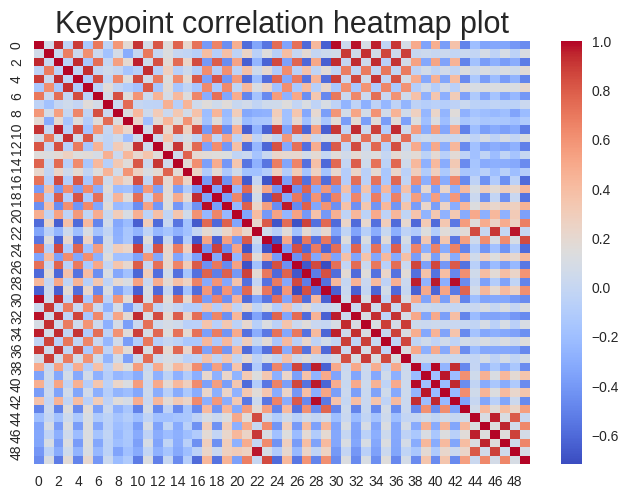

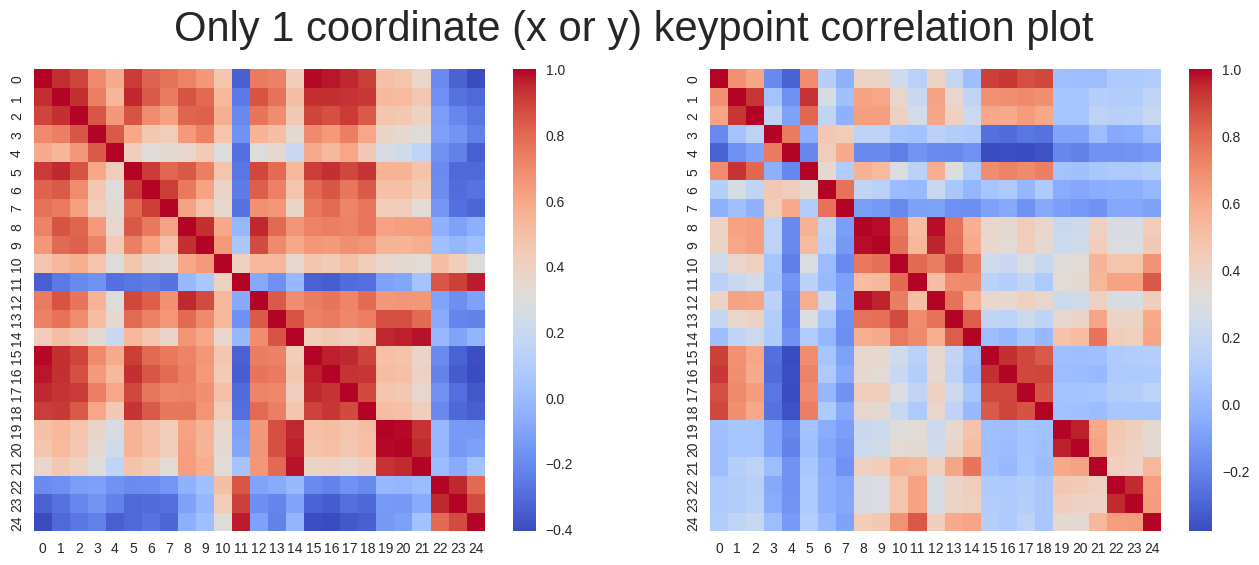

In [82]:
# pre-processing the data: flattening and transposing all of the ground truth poses
poses = GT_poses

GT_poses_reshaped = poses.reshape(-1,50)[:].T

GT_poses_reshaped_only_x = poses.reshape(-1,50)[:,::2].T
GT_poses_reshaped_only_y = poses.reshape(-1,50)[:,1::2].T

# Generating the correlation matrix
plt.title('Keypoint correlation heatmap plot',fontsize=22)
sns.heatmap(np.corrcoef(GT_poses_reshaped),cmap='coolwarm')
plt.show()
### Only x and only y correlation keypoint plots
plt.figure(figsize=(16,6))
plt.suptitle('Only 1 coordinate (x or y) keypoint correlation plot',fontsize=30)
plt.subplot(1,2,1)
sns.heatmap(np.corrcoef(GT_poses_reshaped_only_x),cmap='coolwarm')
plt.subplot(1,2,2)
sns.heatmap(np.corrcoef(GT_poses_reshaped_only_y),cmap='coolwarm')
plt.show()

In [0]:
#Write reflection here ...
"""
time series interpolation seems to maintain allot of the same correlation.

Time series interpolation seems to be the best choice for this data:
MSE is the lowest
Matches the original correlation for the ground truth poses the best
Looking at the mean poses we can see that the poses are very similar
The mean pose we can see that the poses are very similar
The the scale of the generated poses are the same as the original poses
"""